# Importing Required Libraries and Dataset Overview

In [1]:
# Standard Python libraries
import os  # For file and environment variable handling
import re  # For regular expressions (text processing)
import json  # For handling JSON data
import zipfile #For handling ZIP archives (extracting, reading, or creating ZIP files)
import warnings  # To filter out warnings
warnings.filterwarnings('ignore')  # Ignore warnings

# Data processing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization
from wordcloud import WordCloud  # For generating word clouds

# Machine Learning & NLP Libraries
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import accuracy_score, classification_report  # For model evaluation
from sklearn.metrics import confusion_matrix

# NLP Libraries
import nltk  # Natural Language Toolkit for text processing
from nltk.tokenize import sent_tokenize, word_tokenize  # Sentence and word tokenization
from nltk.stem import WordNetLemmatizer  # Lemmatization for text preprocessing
from nltk.corpus import stopwords  # Stopwords for text cleaning


# API & Progress Tracking
import openai  # OpenAI API for GPT models
import scipy.stats as stats  # For statistical analysis
from flask import Flask, render_template, request # For web application
from flask_ngrok import run_with_ngrok  # For running Flask in Jupyter

In [2]:
# Unzip the file
zip_file_path = "transcripts_v3.zip"
extract_folder = "transcripts_data"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Check extracted files
extracted_files = os.listdir(extract_folder)
print(f"Extracted Files: {extracted_files}")

Extracted Files: ['manifest.mf', 'transcripts_v3']


In [3]:
# Define the path to the extracted folder containing the transcripts
transcripts_folder = os.path.join(extract_folder, "transcripts_v3")

# List all files in the transcripts folder and filter only `.txt` files (transcripts)
transcript_files = [f for f in os.listdir(transcripts_folder) if f.endswith(".txt")]

# Print the total number of transcript files found
print(f"Found {len(transcript_files)} transcripts.")

Found 200 transcripts.


In [4]:
# Function to read the content of a transcript text file.
def read_transcript(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return file.read()

In [5]:
# Function to extract only the customer responses from the full transcript.
def extract_customer_responses(transcript_text):
    return " ".join(re.findall(r"Member: (.+)", transcript_text))

In [6]:
# Store extracted transcripts.
transcripts_data = []
for file_name in transcript_files:
    file_path = os.path.join(transcripts_folder, file_name)
    transcript_text = read_transcript(file_path)
    customer_text = extract_customer_responses(transcript_text)

    transcripts_data.append({"file_name": file_name, "customer_transcript": customer_text})

# Convert to DataFrame
transcript_data = pd.DataFrame(transcripts_data)
transcript_data.head()

,file_name,customer_transcript
0,transcript_0.txt,"Hi, I'm calling to get a case pre-authorized. ..."
1,transcript_1.txt,"Hi, I'm calling about a denied claim I receive..."
2,transcript_10.txt,"Hi, I'm calling to schedule an appointment wit..."
3,transcript_100.txt,"Hi, I'm calling about a denied claim I receive..."
4,transcript_101.txt,"Hi, I'm calling to schedule an appointment wit..."


In [7]:
# display an extracted transcript.
transcript_data['customer_transcript'][5]

"Hi, I'm having trouble registering and logging in to my online service account. My member ID is MEM123456. Well, I'm trying to register for the first time, but it keeps saying that my member ID is invalid. I've double-checked that I've entered it correctly. Yes, that's exactly what I'm doing. It's MEM123456. I haven't set up a password yet, I'm trying to register. But I've tried multiple times and it still says my member ID is invalid. Sure, I'll hold. That's strange, I signed up a few days ago. Is there anything I can do to speed up the process? Okay, thank you for trying to help. Can you please escalate the issue and get back to me? Alright, thank you for your help. I'll keep an eye on my email. No, that's all for now. Thank you."

# Sentiment and Call Outcome Analysis with LLMs

In [8]:
#!pip install openai

In [9]:
# API key for openai
openai.api_key = "your_api_key_here"

In [10]:
# Define Few-Shot Prompt
FEW_SHOT_PROMPT = """
You are an AI assistant trained in customer service analysis. Your task is to classify customer transcripts.

### Instructions:
For each transcript, provide:
1. **Sentiment**: (Positive, Negative, Neutral)
2. **Call Outcome**: (Issue Resolved, Follow-up Needed)

### Examples:
1️⃣ Transcript: "I am very happy with the support. They solved my issue quickly!"
   Sentiment: Positive
   Call Outcome: Issue Resolved

2️⃣ Transcript: "The service is terrible. My issue is still not fixed!"
   Sentiment: Negative
   Call Outcome: Follow-up Needed

3️⃣ Transcript: "It was okay. Took longer than expected, but they helped me."
   Sentiment: Neutral
   Call Outcome: Issue Resolved

---

Now analyze the following customer transcript:
Transcript: "{text}"

Provide the response in this JSON format:
{{
  "sentiment": "...",
  "call_outcome": "..."
}}
"""

In [11]:
# Function to classify sentiment and call outcome using GPT-4.
def analyze_transcript(text):
    
    if not text.strip():  # If empty, return default values
        return {"sentiment": "No Data", "call_outcome": "No Data"}
    
    prompt = FEW_SHOT_PROMPT.format(text=text)

    try:
        response = openai.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an AI trained for customer service analysis."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )

        # Extract response correctly
        output_text = response.choices[0].message.content
        return json.loads(output_text)  # Convert string to JSON
    except Exception as e:
        return {"error": str(e)}

In [12]:
# Sample text to analyze sentiment and call outcome
sample_text = "I am really unhappy"

# Passing the sample text to the 'analyze_transcript' function to determine sentiment and call outcome
result = analyze_transcript(sample_text)

# Printing the result, which contains predicted sentiment and call outcome
print(result)

{'sentiment': 'Negative', 'call_outcome': 'Follow-up Needed'}


In [13]:
# Initialize empty lists to store predicted sentiment and call outcome
sentiments = []
call_outcomes = []

# Iterate through each customer transcript in the DataFrame
for text in transcript_data["customer_transcript"]:
    # Analyze the transcript using the AI model to get sentiment and call outcome
    response = analyze_transcript(text)

    # Append the predicted sentiment to the sentiments list (default to "Unknown" if missing)
    sentiments.append(response.get("sentiment", "Unknown"))

    # Append the predicted call outcome to the call_outcomes list (default to "Unknown" if missing)
    call_outcomes.append(response.get("call_outcome", "Unknown"))

# Add the predicted sentiments as a new column in the DataFrame
transcript_data["sentiment"] = sentiments

# Add the predicted call outcomes as a new column in the DataFrame
transcript_data["call_outcome"] = call_outcomes

# Save the updated DataFrame with predictions to a CSV file
transcript_data.to_csv("labeled_transcripts.csv", index=False)

In [15]:
# Load the labeled transcript data from a CSV file
transcript_data = pd.read_csv("labeled_transcripts.csv")

# Display the first 5 rows of the DataFrame to check the data
transcript_data.head()

,file_name,customer_transcript,sentiment,call_outcome
0,transcript_0.txt,"Hi, I'm calling to get a case pre-authorized. ...",Neutral,Follow-up Needed
1,transcript_1.txt,"Hi, I'm calling about a denied claim I receive...",Negative,Follow-up Needed
2,transcript_10.txt,"Hi, I'm calling to schedule an appointment wit...",Positive,Issue Resolved
3,transcript_100.txt,"Hi, I'm calling about a denied claim I receive...",Positive,Follow-up Needed
4,transcript_101.txt,"Hi, I'm calling to schedule an appointment wit...",Positive,Issue Resolved


In [16]:
# Count the occurrences of each sentiment category in the "sentiment" column
sentiment_counts = transcript_data["sentiment"].value_counts()

# Display the count of each sentiment category
print(sentiment_counts)

Positive    113
Neutral      73
Negative     14
Name: sentiment, dtype: int64


In [17]:
# Count the occurrences of each call outcome category in the "call_outcome" column
call_outcome_counts = transcript_data["call_outcome"].value_counts()

# Display the count of each call outcome category
print(call_outcome_counts)


Issue Resolved      116
Follow-up Needed     84
Name: call_outcome, dtype: int64


In [18]:
# Loop through all customer transcripts that have a "Negative" sentiment
for txt in transcript_data[transcript_data['sentiment'] == 'Negative']['customer_transcript']:
    # Print the customer transcript with negative sentiment
    print(txt)
    
    # Print a separator for better readability between different transcripts
    print('*************************')


Hi, I'm calling about a denied claim I received for my recent medical service. I was told that my policy doesn't cover it, but I'm certain it should be covered under my new policy. My member ID is MEM123456. The claim number is CLM789012, and the date of service was February 10th. I switched policies on January 1st. I was told that the new policy would cover the service I received, but the denial letter says it's not covered. That's frustrating. How can we get this resolved? No, that's all. Thank you for your help. Thank you.
*************************
Hi, I'm calling about a denied claim I received. I'm very frustrated because I'm certain it should be covered. My name is Emily Wilson, and my member ID is MEM123456. Yes, of course. The claim was for a doctor's visit, and the reason for the denial was that it's not covered under my policy. But I had switched to a new policy last month, and I'm certain that this service is covered under the new policy. ( pause ) Yes, I'm still holding. Th

# Model Performance Evaluation

In [19]:
# Split the dataset while maintaining sentiment distribution
train_df, test_df = train_test_split(transcript_data, test_size=0.5, 
                                     stratify=transcript_data["sentiment"],
                                     random_state=42)

In [20]:
# Calculate the proportion (percentage) of each sentiment category in the dataset
sentiment_distribution = transcript_data["sentiment"].value_counts(normalize=True)

# Display the sentiment distribution
print(sentiment_distribution)


Positive    0.565
Neutral     0.365
Negative    0.070
Name: sentiment, dtype: float64


In [21]:
# Verify the sentiment distribution in the test set
sentiment_distribution_test = test_df["sentiment"].value_counts(normalize=True)

# Display the sentiment distribution in percentages
print(sentiment_distribution_test)


Positive    0.57
Neutral     0.36
Negative    0.07
Name: sentiment, dtype: float64


In [22]:
# Calculate the proportion (percentage) of each call outcome category in the dataset
call_outcome_distribution = transcript_data["call_outcome"].value_counts(normalize=True)

# Display the call outcome distribution
print(call_outcome_distribution)

Issue Resolved      0.58
Follow-up Needed    0.42
Name: call_outcome, dtype: float64


In [23]:
# Verify the call outcome distribution in the test set
call_outcome_distribution_test = test_df["call_outcome"].value_counts(normalize=True)

# Display the call outcome distribution in percentages
print(call_outcome_distribution_test)


Issue Resolved      0.64
Follow-up Needed    0.36
Name: call_outcome, dtype: float64


In [24]:
# Reset the index of the test DataFrame and drop the old index
test_df.reset_index(inplace=True, drop=True)

# Display the first 5 rows of the updated test DataFrame
test_df.head()

,file_name,customer_transcript,sentiment,call_outcome
0,transcript_107.txt,"Hi, I'm calling to schedule an appointment wit...",Positive,Issue Resolved
1,transcript_183.txt,"Hi, I'm calling about a denied claim I receive...",Negative,Issue Resolved
2,transcript_162.txt,"Hi, I'm having trouble registering and logging...",Positive,Issue Resolved
3,transcript_98.txt,"Hi, I'm calling about a denied claim I receive...",Positive,Issue Resolved
4,transcript_156.txt,"Hi, I'm calling about my recent medical bill. ...",Positive,Issue Resolved


In [25]:
# Save the test DataFrame as a CSV file without including the index
test_df.to_csv('test_transcripts.csv', index=False)

In [26]:
# Load the manually labeled test dataset from a CSV file into a Pandas DataFrame
test_data = pd.read_csv('test_labeled_transcripts.csv')

In [27]:
# Generate and print the classification report to evaluate sentiment predictions
print(classification_report(test_data['sentiment_labeled'], test_data['sentiment']))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         6
     Neutral       0.76      0.96      0.85        26
    Positive       0.98      0.88      0.93        68

    accuracy                           0.91       100
   macro avg       0.91      0.95      0.93       100
weighted avg       0.93      0.91      0.91       100



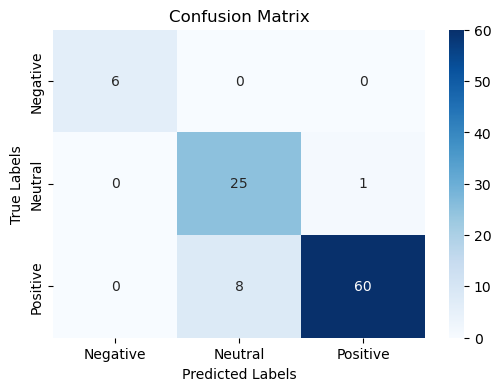

In [28]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_data['sentiment_labeled'],test_data['sentiment'])

# Create a new figure for the heatmap
plt.figure(figsize=(6, 4))

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

# Set labels and title
plt.xlabel('Predicted Labels')  # X-axis represents model predictions
plt.ylabel('True Labels')       # Y-axis represents actual ground truth labels
plt.title('Confusion Matrix')   # Title of the plot

# Save the confusion matrix as an image file
plt.savefig('confusion_matrix_sentiment.png')

# Display the plot
plt.show()

In [29]:
# Generate and print the classification report for call outcome predictions
print(classification_report(test_data['outcome_labeled'], test_data['call_outcome']))

                  precision    recall  f1-score   support

Follow-up Needed       0.88      0.92      0.90        38
  Issue Resolved       0.95      0.92      0.93        62

        accuracy                           0.92       100
       macro avg       0.91      0.92      0.92       100
    weighted avg       0.92      0.92      0.92       100



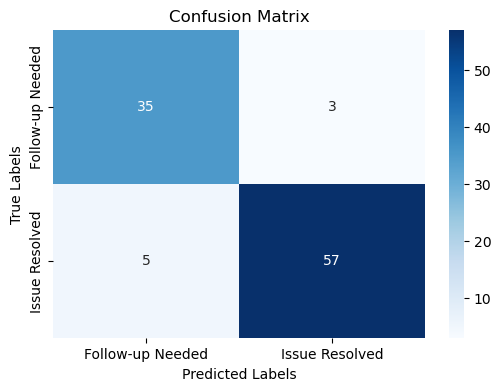

In [30]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_data['outcome_labeled'], test_data['call_outcome'])

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Follow-up Needed', 'Issue Resolved'],
            yticklabels=['Follow-up Needed', 'Issue Resolved'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_outcome.png')
plt.show()

# Data Insights: Statistical and Visual Exploration

In [31]:
# Create a contingency table
contingency_table = pd.crosstab(transcript_data["sentiment"], transcript_data["call_outcome"])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")

# Interpret the results
if p <  0.05:
    print("There is a **significant relationship** between Sentiment and Call Outcome.")
else:
    print("No significant relationship found between Sentiment and Call Outcome.")


Chi-Square Test Results:
Chi-Square Statistic: 99.8811
P-value: 0.0000
There is a **significant relationship** between Sentiment and Call Outcome.


In [32]:
# Calculate the percentage distribution of each sentiment category
sentiment_percentage = round(transcript_data['sentiment'].value_counts(normalize=True) * 100, 2).reset_index()

# Rename the columns for better readability
sentiment_percentage.columns = ['Sentiment', 'Percentage (%)']

# Display the resulting DataFrame
sentiment_percentage

,Sentiment,Percentage (%)
0,Positive,56.5
1,Neutral,36.5
2,Negative,7.0


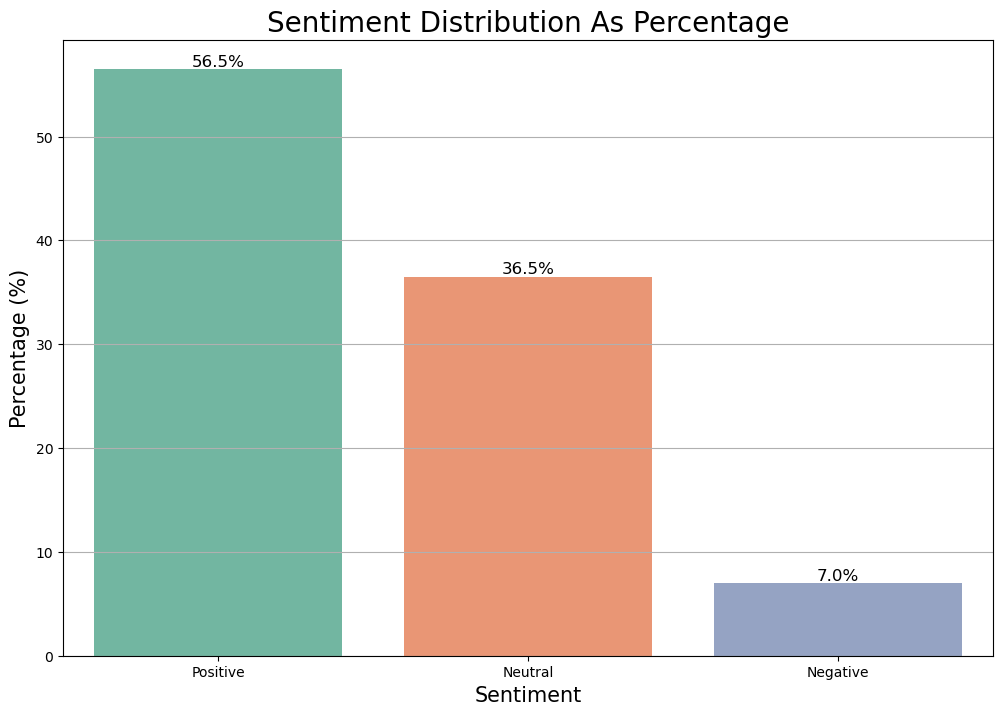

In [33]:
# Set the size of the plot.
plt.figure(figsize=(12,8))

# Create a barplot.
ax = sns.barplot(x=sentiment_percentage['Sentiment'],
                                y=sentiment_percentage['Percentage (%)'],
                                palette="Set2")

# Add a title and axis labels with font size to the plot.
plt.title('Sentiment Distribution As Percentage', fontsize=20)
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Percentage (%)', fontsize=15)

# Add percentage labels on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')
    
plt.grid(axis='y')
plt.savefig('sentiment_dist.png')
plt.show()

In [34]:
# Calculate the percentage distribution of each call outcome category
call_outcome_percentage = round(transcript_data['call_outcome'].value_counts(normalize=True) * 100, 2).reset_index()

# Rename the columns for better readability
call_outcome_percentage.columns = ['Call Outcome', 'Percentage (%)']

# Display the resulting DataFrame
call_outcome_percentage


,Call Outcome,Percentage (%)
0,Issue Resolved,58.0
1,Follow-up Needed,42.0


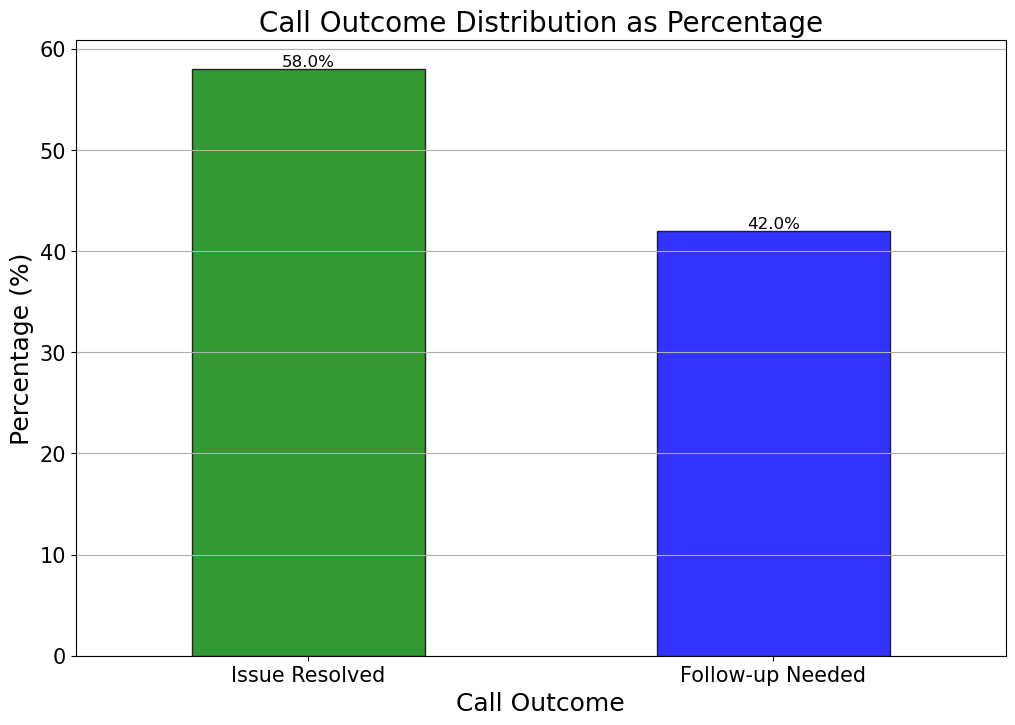

In [35]:
# Create a bar plot to visualize the distribution of call outcomes
fig, ax = plt.subplots()  # Create a figure and axis

# Plot the call outcome percentages as a bar chart
ax = call_outcome_percentage.plot.bar(
    x='Call Outcome',  # X-axis represents call outcomes (Resolved, Follow-up Needed)
    y='Percentage (%)',  # Y-axis represents percentage values
    ax=ax,  # Use the existing axis
    color=['Green', 'Blue'],  # Set colors: Green for Resolved, Red for Follow-up Needed
    alpha=0.8,  # Set transparency for better visibility
    edgecolor='black',  # Add black borders to bars
    legend=False  # Hide legend (not needed for this visualization)
)

# Set axis labels and title
ax.set_xlabel('Call Outcome', fontsize=18)  # Label for X-axis
ax.set_ylabel('Percentage (%)', fontsize=18)  # Label for Y-axis
ax.set_title('Call Outcome Distribution as Percentage', fontsize=20)  # Title of the plot
ax.tick_params(axis='both', labelsize=15)  # Set tick label size for better readability

# Remove unnecessary spines (top and right borders of the plot)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add percentage labels on top of bars
for p in ax.patches:  # Loop through each bar in the bar chart
    ax.annotate(f"{p.get_height()}%",  # Display percentage value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Positioning on top of bars
                ha='center', va='bottom', fontsize=12, color='black')  # Alignment and text properties

# Customize the appearance of the plot
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.gca().spines['top'].set_visible(True)  # Make the top border visible
plt.gca().spines['right'].set_visible(True)  # Make the right border visible

# Set figure size for better visibility
plt.gcf().set_size_inches((12, 8))  # gcf() stands for "get current figure"

# Add horizontal gridlines to improve readability
ax.yaxis.grid(True)

# Save the figure as an image file
plt.savefig('call_outcome_dist.png')

# Display the plot
plt.show()

In [36]:
# Count occurrences of each sentiment within each Call Outcome
sentiment_counts = transcript_data.groupby(["call_outcome", "sentiment"]).size().reset_index(name="Count")

# Calculate percentages within each Call Outcome
total_counts = sentiment_counts.groupby("call_outcome")["Count"].transform("sum")
sentiment_counts["Percentage"] = round((sentiment_counts["Count"] / total_counts) * 100,1)
sentiment_counts

,call_outcome,sentiment,Count,Percentage
0,Follow-up Needed,Negative,10,11.9
1,Follow-up Needed,Neutral,61,72.6
2,Follow-up Needed,Positive,13,15.5
3,Issue Resolved,Negative,4,3.4
4,Issue Resolved,Neutral,12,10.3
5,Issue Resolved,Positive,100,86.2


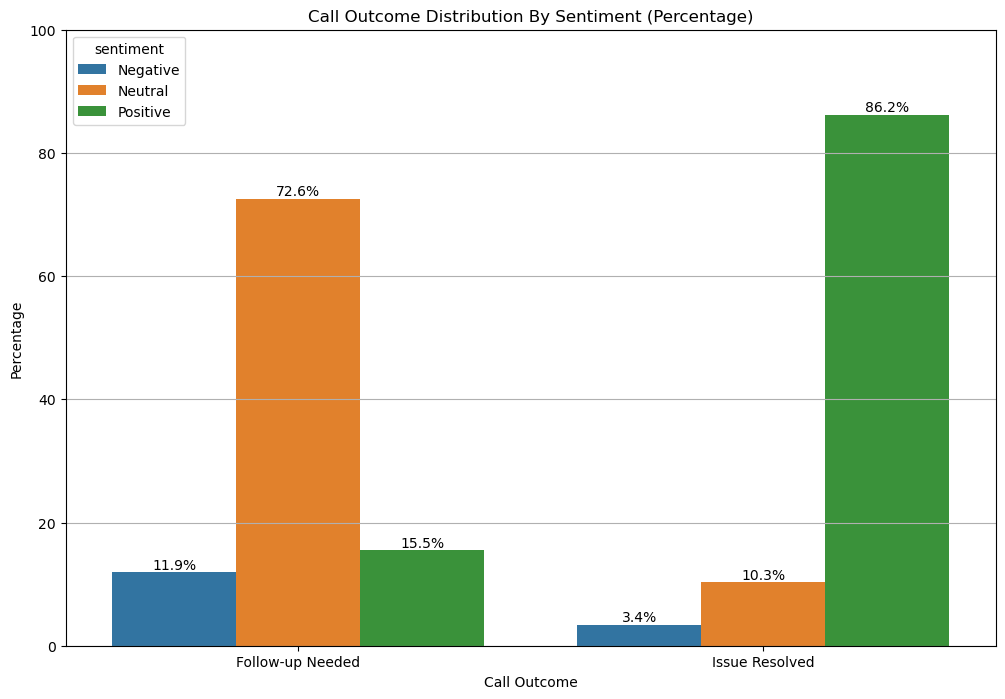

In [37]:
# Plot with seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="call_outcome", y="Percentage", hue="sentiment", data=sentiment_counts)

# Add percentage labels to bars
for p in ax.patches:
    percentage = f"{p.get_height():.1f}%"  # Format percentage with 1 decimal place
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Adjust labels and title
plt.ylabel("Percentage")
plt.xlabel("Call Outcome")
plt.title("Call Outcome Distribution By Sentiment (Percentage)")
plt.ylim(0, 100)  # Ensure the y-axis goes up to 100%

plt.grid(axis='y')
plt.savefig('outcome_dist_by_sentiment.png')
plt.show()


In [38]:
# Count occurrences of each sentiment within each Call Outcome
outcome_counts = transcript_data.groupby(["sentiment", "call_outcome"]).size().reset_index(name="Count")

# Calculate percentages within each Call Outcome
total_counts = outcome_counts.groupby("sentiment")["Count"].transform("sum")
outcome_counts["Percentage"] = round((outcome_counts["Count"] / total_counts) * 100,1)
outcome_counts

,sentiment,call_outcome,Count,Percentage
0,Negative,Follow-up Needed,10,71.4
1,Negative,Issue Resolved,4,28.6
2,Neutral,Follow-up Needed,61,83.6
3,Neutral,Issue Resolved,12,16.4
4,Positive,Follow-up Needed,13,11.5
5,Positive,Issue Resolved,100,88.5


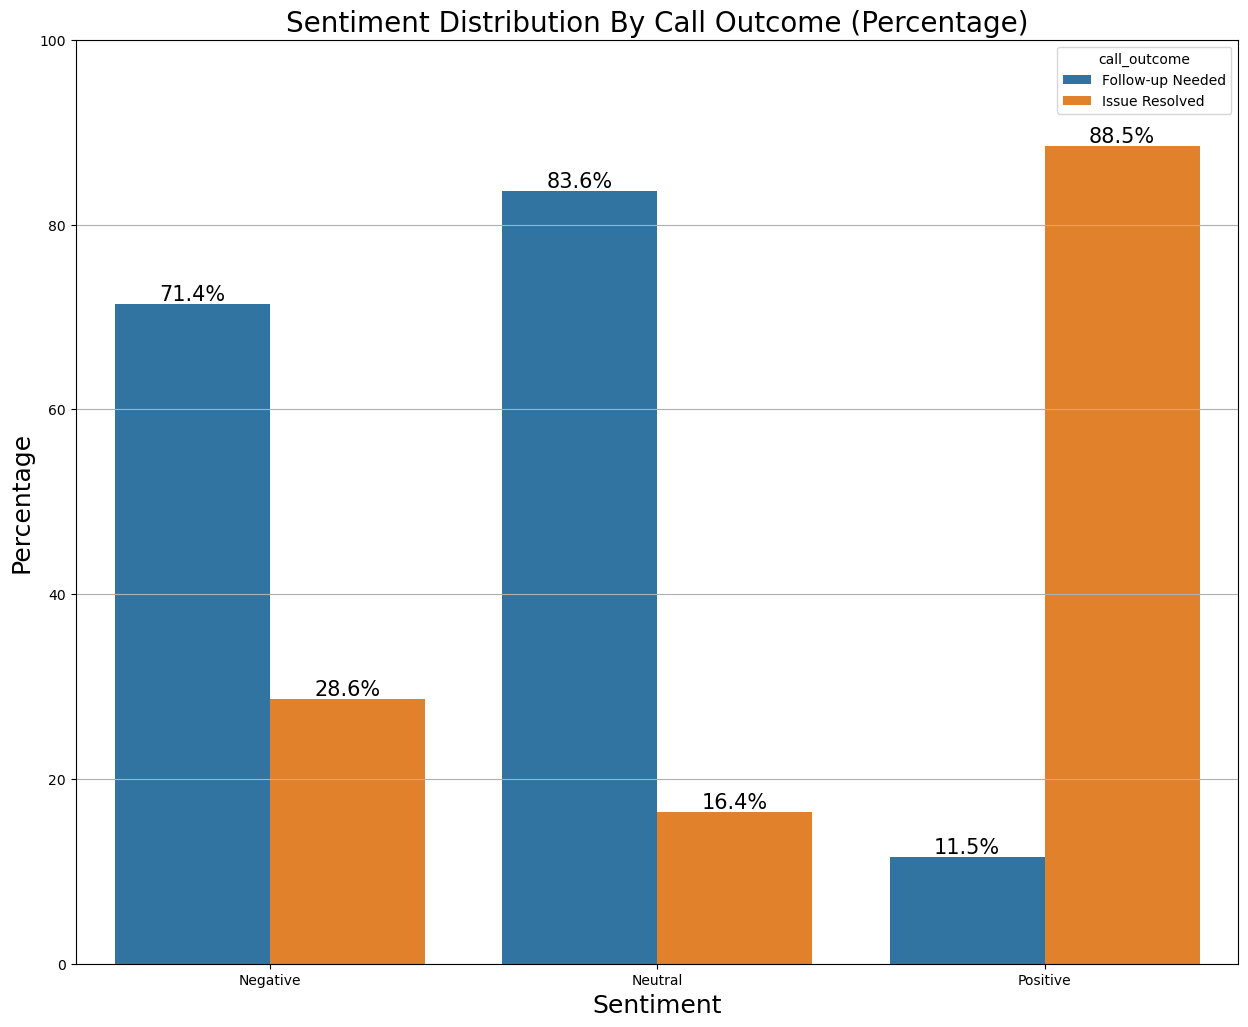

In [39]:
# Plot with seaborn
plt.figure(figsize=(15, 12))
ax = sns.barplot(x="sentiment", y="Percentage", hue="call_outcome", data=outcome_counts)

# Add percentage labels to bars
for p in ax.patches:
    percentage = f"{p.get_height():.1f}%"  # Format percentage with 1 decimal place
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=15, color='black')

# Adjust labels and title
plt.ylabel("Percentage", fontsize=18)
plt.xlabel("Sentiment", fontsize=18)
plt.title("Sentiment Distribution By Call Outcome (Percentage)", fontsize=20)
plt.ylim(0, 100)  # Ensure the y-axis goes up to 100%

plt.grid(axis='y')
plt.savefig('sentiment_dist_by_outcome.png')
plt.show()

In [40]:
# Iterate through customer transcripts where:
# - Call Outcome is 'Issue Resolved'
# - Sentiment is 'Negative'
for txt in transcript_data[(transcript_data['call_outcome'] == 'Issue Resolved') & (transcript_data['sentiment'] == 'Negative')]['customer_transcript']:
    
    # Print the transcript text
    print(txt)
    
    # Add a separator for better readability
    print('***************************')


Hi, I'm having trouble registering and logging in to my online service account. I've tried multiple times, but I keep getting an error message. My member ID is MEM123456. It says "Invalid username or password." But I'm positive I'm entering the correct information. It's jsmith@email.com. And yeah, I just tried logging in again and got the same error message. (pauses) Yeah, I'm still holding. (frustrated) That's ridiculous. I've only tried logging in a few times. And now you're telling me my account is locked? (sighs) Fine. (skeptical) Okay... what's the temporary password? (pauses) Okay, I'm logged in now. But this is really frustrating. I shouldn't have had to call technical support just to log in to my account. (hesitant) No, that's all. Thanks, I guess. (hangs up)
***************************
Hi, I'm having some trouble registering and logging in to my online service account. My member ID is MEM456789.  It just says "Invalid username or password" every time I try to log in. I've trie

In [41]:
# Load the list of English stopwords from NLTK
stop_words = stopwords.words('english')

# Add custom words to the stopword list
for i in ["hi", "im", "thats"]:  # Words to be added
    stop_words.append(i)  # Append each word to the stopword list

In [42]:
# Define the text cleaning function
def cleaning(data):
    
    # 1. Tokenization: Split text into words (tokens), remove apostrophes, and convert to lowercase
    text_tokens = word_tokenize(data.replace("'", "").lower())
    
    # 2. Remove punctuation and numbers: Keep only alphabetic words
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    # 3. Removing Stopwords: Exclude common words that don’t add much meaning
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    # 4. Lemmatization: Convert words to their base form (e.g., "running" → "run")
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    # 5. Join the cleaned tokens back into a single string
    return " ".join(text_cleaned)


In [43]:
# Filter the dataset to select only negative sentiment customer transcripts
negative_sentences = transcript_data[transcript_data["sentiment"] == 'Negative']["customer_transcript"]

# Apply the text cleaning function to each negative transcript
negative_sentences = negative_sentences.apply(cleaning)

# Join all cleaned negative transcripts into a single string for further analysis (e.g., word cloud)
negative_words = " ".join(negative_sentences)

In [44]:
# Filter the dataset to select only neutral sentiment customer transcripts
neutral_sentences = transcript_data[transcript_data["sentiment"] == 'Neutral']["customer_transcript"]

# Apply the text cleaning function to each neutral transcript
neutral_sentences = neutral_sentences.apply(cleaning)

# Join all cleaned neutral transcripts into a single string for further analysis (e.g., word cloud)
neutral_words = " ".join(neutral_sentences)


In [45]:
# Filter the dataset to select only positive sentiment customer transcripts
positive_sentences = transcript_data[transcript_data["sentiment"] == 'Positive']["customer_transcript"]

# Apply the text cleaning function to each positive transcript
positive_sentences = positive_sentences.apply(cleaning)

# Join all cleaned positive transcripts into a single string for further analysis (e.g., word cloud)
positive_words = " ".join(positive_sentences)


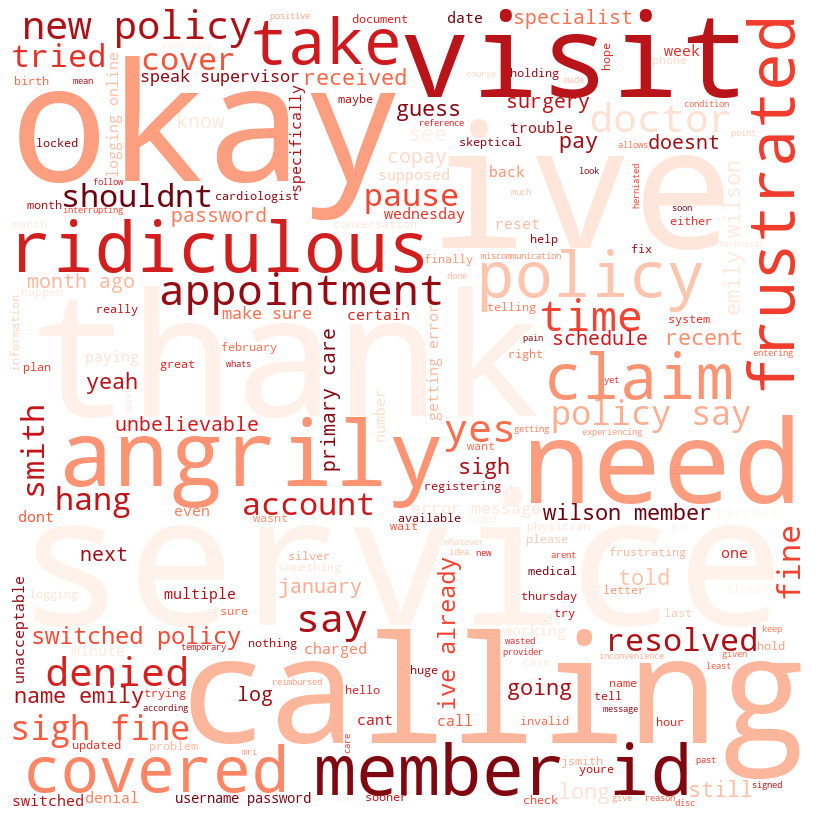

In [46]:
# Create the word cloud for negative sentiment words
wordcloud_negative = WordCloud(
    width=800,  
    height=800, 
    background_color="white",
    colormap="Reds",  # Set color map
    margin=0  # Remove extra space
)

wordcloud_negative.generate(negative_words)

# Plot the word cloud
plt.figure(figsize=(8, 8))  # Adjust figure size
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.tight_layout(pad=0)  # Remove padding
plt.savefig('negative_wordcloud.png')
plt.show()

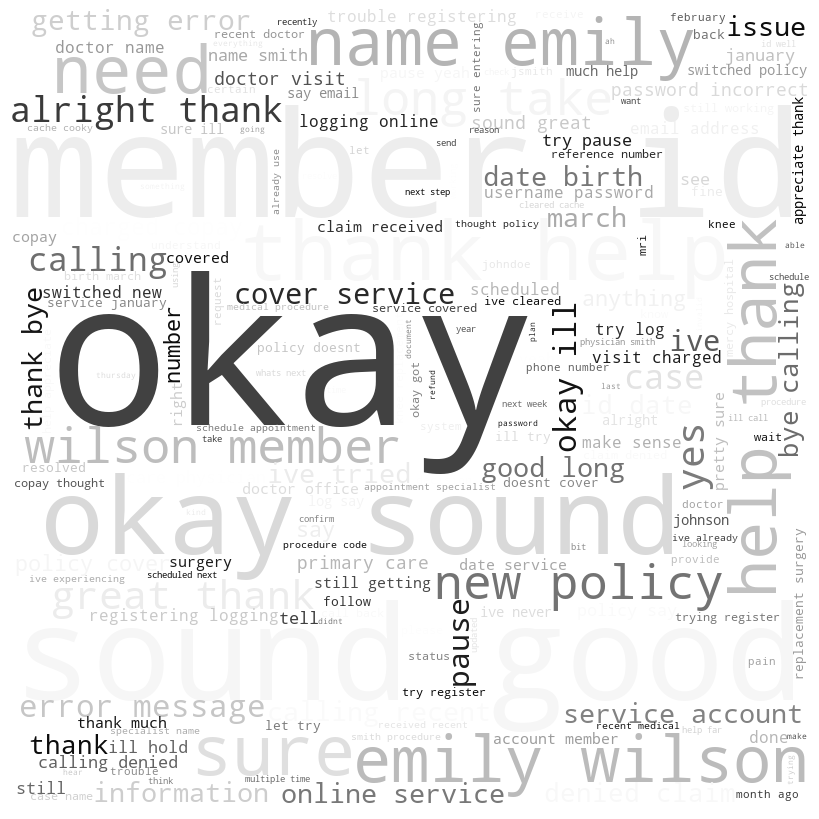

In [47]:
# Create the word cloud for neutral sentiment words
wordcloud_neutral = WordCloud(
    width=800,  
    height=800, 
    background_color="white",
    colormap="Greys",  # Set color map
    margin=0  # Remove extra space
)

wordcloud_neutral.generate(neutral_words)

# Plot the word cloud
plt.figure(figsize=(8, 8))  # Adjust figure size
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.tight_layout(pad=0)  # Remove padding
plt.savefig('neutral_wordcloud.png')
plt.show()

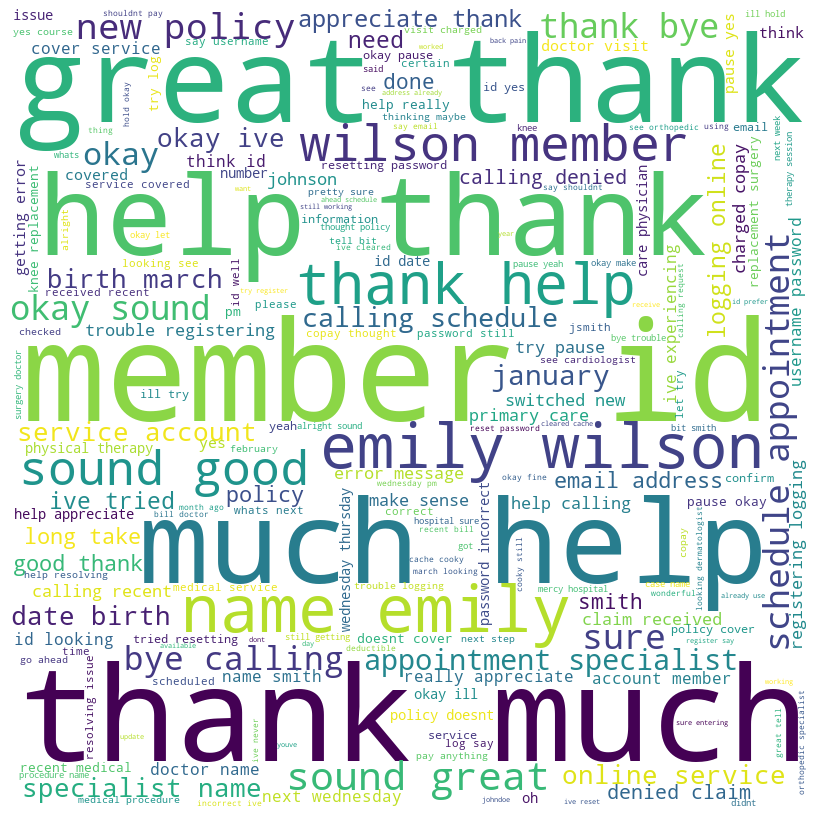

In [48]:
# Create the word cloud for positive sentiment words
wordcloud_positive = WordCloud(
    width=800,  
    height=800, 
    background_color="white",
    margin=0  # Remove extra space
)
wordcloud_positive.generate(positive_words)

# Plot the word cloud
plt.figure(figsize = (8,8))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('positive_wordcloud.png')
plt.show()

# Deployment 

In [49]:
#!pip install flask

In [50]:
# Function to extract only customer responses from the transcript
def extract_customer_responses(transcript):
    """
    Extracts only the customer's responses from a full conversation transcript.
    
    Args:
        transcript (str): The full call transcript.
    
    Returns:
        str: A cleaned version containing only the customer's responses.
    """
    return " ".join(re.findall(r"Member: (.+)", transcript))  # Extracts lines starting with "Member: "

In [51]:
# Function to analyze transcript sentiment and call outcome using GPT-4 Turbo
def analyze_transcript(transcript):
    """
    Uses OpenAI's GPT-4 Turbo to classify sentiment and call outcome from the customer's responses.

    Args:
        transcript (str): The full call transcript.
    
    Returns:
        tuple: (sentiment, sentiment_icon, outcome, outcome_icon)
    """

    try:
        # Extract only the customer responses
        customer_text = extract_customer_responses(transcript)

        # If no customer responses found, return default values
        if not customer_text.strip():  
            return "No Customer Response", "❌", "No Data", "❌"

        # Format the prompt for the LLM
        prompt = FEW_SHOT_PROMPT.format(text=customer_text)

        # Send request to OpenAI's GPT-4 Turbo model
        response = openai.chat.completions.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
        )

        # Extract response from the model
        result = response.choices[0].message.content
        print("🔹 OpenAI Response:", result)  # Debugging print statement

        # Initialize default labels
        sentiment = "Neutral"
        sentiment_icon = "😐"
        outcome = "Follow-up Needed"
        outcome_icon = "🔄"

        # Check for sentiment classification in model response
        if "Positive" in result:
            sentiment = "Positive"
            sentiment_icon = "😊"
        elif "Negative" in result:
            sentiment = "Negative"
            sentiment_icon = "😡"

        # Check for call outcome classification in model response
        if "Resolved" in result:
            outcome = "Issue Resolved"
            outcome_icon = "✅"

        return sentiment, sentiment_icon, outcome, outcome_icon

    except Exception as e:
        # Handle API errors gracefully
        print("❌ OpenAI API Error:", e)
        return "Error", "❌", "Error", "❌"


In [52]:
# Define Flask App
app = Flask(__name__)
run_with_ngrok(app)  # Runs Flask inside Jupyter Notebook

# Define Flask route
@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        if "file" not in request.files:
            return "<h2>⚠️ No file uploaded.</h2><a href='/'>⬅️ Go Back</a>"

        file = request.files["file"]
        if file.filename == "":
            return "<h2>⚠️ No file selected.</h2><a href='/'>⬅️ Go Back</a>"

        # Read transcript content
        transcript_text = file.read().decode("utf-8")

        # Extract customer responses
        customer_text = extract_customer_responses(transcript_text)

        if not customer_text.strip():  # No customer response found
            return "<h2>⚠️ No customer responses found in transcript.</h2><a href='/'>⬅️ Go Back</a>"

        # Get AI analysis
        sentiment, sentiment_icon, outcome, outcome_icon = analyze_transcript(transcript_text)

        return f"""
        
    
        <h2>📞 AI-Powered Call Analysis</h2>
        
        <h3>📜 Full Call Transcript</h3>
        <textarea rows="8" cols="100" readonly>{transcript_text}</textarea>
        
        <h3>📃 Extracted Customer Responses</h3>
        <textarea rows="8" cols="100" readonly>{customer_text}</textarea>
        
        <h3>📝 AI Analysis Result</h3>
        <div style="background:#f9f9f9; padding:15px; border-radius:8px; margin-top:20px; font-size:18px;">
            <p style="font-size: 24px;"><strong>Sentiment:</strong> {sentiment_icon} {sentiment}</p>
            <p style="font-size: 24px;"><strong>Call Outcome:</strong> {outcome_icon} {outcome}</p>
        </div>
        <br>
        <a href="/">⬅️ Upload Another File</a>
        """

    return """
    <h2>📞 AI-Powered Call Analysis</h2>
    <p>Upload a call transcript (.txt) and analyze sentiment & call outcome.</p>
    <form action="/" method="post" enctype="multipart/form-data">
        <input type="file" name="file" accept=".txt" required>
        <br><br>
        <button type="submit">🔍 Run Analysis</button>
    </form>
    """

In [53]:
# Run Flask App
app.run()